# Playing around with optimizing distance metrics for clustering algorithms...
## Let's start with a simple algorithm

* Following the method outlined in http://ai.stanford.edu/~ang/papers/nips02-metric.pdf

In [3]:
%matplotlib inline

import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

First generate some fake data with two clusters:

In [4]:
N = 200

x1 = np.random.normal(1,1,N)
y1 = np.random.normal(1,1,N)

x2 = np.random.normal(10,1,N)
y2 = np.random.normal(1,1,N)

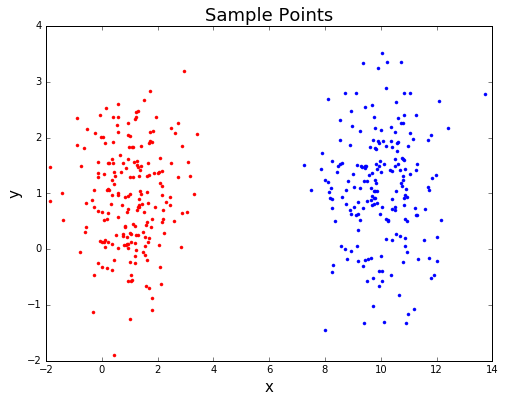

In [5]:
fig = plt.figure()
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.title("Sample Points",size = 18)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
fig.set_size_inches(8, 6)

Define the function J which needs to be minimized in order to decrease the distance between points in a cluster, while maintaining the inter-cluster distance.  The parameters theta[0] and theta[1] scale distances in the x and y directions respectively.  See section 2.1 of http://ai.stanford.edu/~ang/papers/nips02-metric.pdf for details.

In [6]:
def J(theta):
    function = 0
    for i in range(len(x1)):
        for j in range(len(x2)):
            function += ( theta[0]*(x1[i]-x1[j])**2 + theta[1]*(y1[i]-y1[j])**2 +
                         theta[0]*(x2[i]-x2[j])**2 + theta[1]*(y2[i]-y2[j])**2 )
    constraint = 0
    for i in range(len(x1)):
        j = np.random.randint(0,len(x1)-1)
        constraint += abs(theta[0]*(x1[i]-x2[j])) + abs(theta[1]*(y1[i]-y2[j]))
    
    return function + np.log(constraint)    

Construct the constraints so that the optimization keeps theta[0] and theta[1] strictly greater than zero.

In [7]:
def theta1(theta):
    return theta[0]

def theta2(theta):
    return theta[1]

cons = [{'type': 'ineq', 'fun': theta1}, {'type': 'ineq', 'fun': theta2}]
bnds = [(0,None),(0,None)]

Optimize J with respect to theta:

In [8]:
theta_init = np.random.random(2)
opt = optimize.minimize(fun=J,x0=theta_init,bounds=bnds,constraints=cons)
theta_min = opt.x
theta_min = theta_min/max(theta_min) # normalize theta (values of theta are arbitrary up to a normalization factor)
theta_min

array([ 1.        ,  0.83557035])

Plot the results:

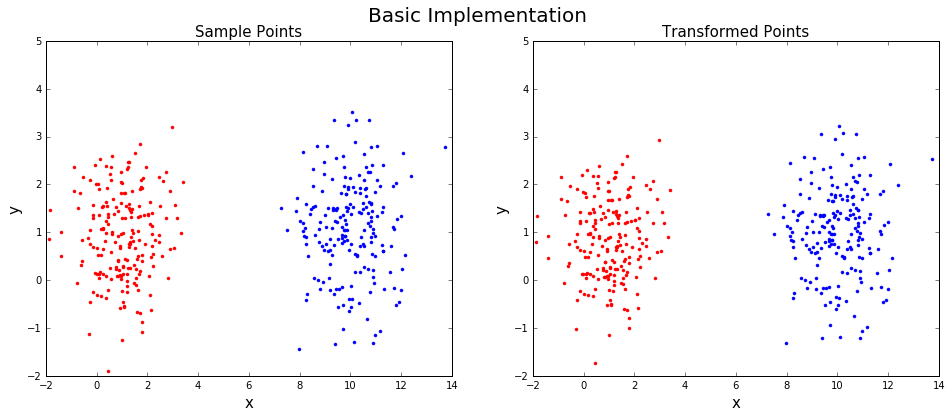

In [9]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Sample Points",size=15)

plt.subplot(122)
plt.plot(np.sqrt(theta_min[0])*x1,np.sqrt(theta_min[1])*y1,'r.')
plt.plot(np.sqrt(theta_min[0])*x2,np.sqrt(theta_min[1])*y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Transformed Points",size=15)

plt.suptitle("Basic Implementation",size=20)

fig.set_size_inches(16, 6)

## Now let's try out some more sophisticated metric optimization methods

* Large Margin Nearest Neighbor (LMNN)
* Least Squares Metric Learning (LSML)
* Neighborhood Components Analysis (NCA) algorithms 

see https://all-umass.github.io/metric-learn/metric_learn.lmnn.html!

In [12]:
from metric_learn import LMNN, LSML_Supervised, NCA

Construct the matrix formulation of the two cluster data:

In [13]:
X = np.vstack( (np.hstack((x1,x2)) , np.hstack((y1,y2))) )
X = np.transpose(X)

Y = np.hstack( (np.zeros(N),np.ones(N)) )

### Large Margin Nearest Neighbor (LMNN) algorithm

In [14]:
lmnn = LMNN(k=2, learn_rate=1e-6)
lmnn_metric=np.matrix(lmnn.fit(X,Y).metric())
lmnn_metric # optimized metric learned from the data

matrix([[ 0.00061917, -0.00032646],
        [-0.00032646,  0.00032604]])

In [15]:
X_transform = lmnn_metric * np.transpose(np.matrix(X)) # data points in X transformed by this optimized metric

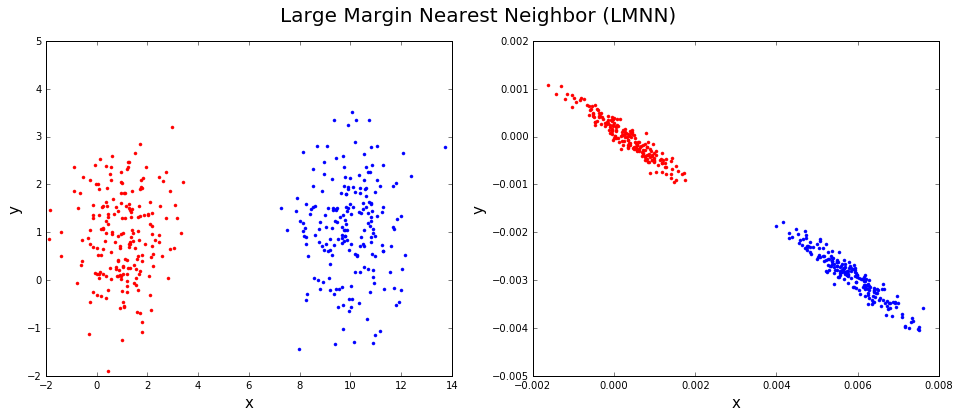

In [16]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
plt.plot(X_transform[0,0:N-1],X_transform[1,0:N-1],'r.')
plt.plot(X_transform[0,N:],X_transform[1,N:],'b.')
#plt.xlim(-2,14)
#plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Large Margin Nearest Neighbor (LMNN)",size=20)

fig.set_size_inches(16, 6)

### Least Squares Metric Learning (LSML)

In [17]:
lsml = LSML_Supervised(num_constraints=200)
lsml_metric = np.matrix(lsml.fit(X,Y).metric())
lsml_metric # optimized metric learned from the data

matrix([[ 21.25930657,   0.43018284],
        [  0.43018284,   0.92248109]])

In [18]:
X_transform = lsml_metric * np.transpose(np.matrix(X)) # data points in X transformed by this optimized metric

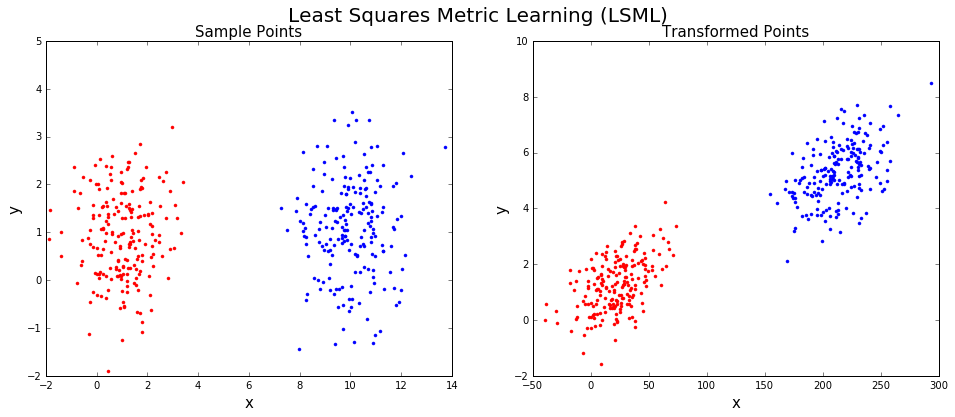

In [19]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Sample Points",size=15)

plt.subplot(122)
plt.plot(X_transform[0,0:N-1],X_transform[1,0:N-1],'r.')
plt.plot(X_transform[0,N:],X_transform[1,N:],'b.')
#plt.xlim(-2,14)
#plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Transformed Points",size=15)

plt.suptitle("Least Squares Metric Learning (LSML)",size=20)

fig.set_size_inches(16, 6)

### Neighborhood Components Analysis (NCA)

In [21]:
nca = NCA(max_iter=1000, learning_rate=0.01)
nca_metric = np.matrix(nca.fit(X, Y).metric())
nca_metric # optimized metric learned from the data

matrix([[ 0.46052101, -0.00929115],
        [-0.00929115,  0.0336909 ]])

In [23]:
X_transform = nca_metric * np.transpose(np.matrix(X)) # data points in X transformed by this optimized metric

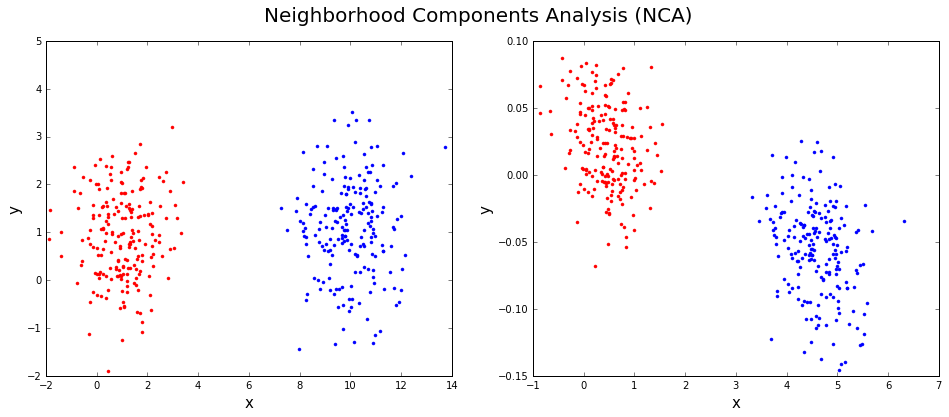

In [24]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'r.')
plt.plot(x2,y2,'b.')
plt.xlim(-2,14)
plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
plt.plot(X_transform[0,0:N-1],X_transform[1,0:N-1],'r.')
plt.plot(X_transform[0,N:],X_transform[1,N:],'b.')
#plt.xlim(-2,14)
#plt.ylim(-2,5)
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Neighborhood Components Analysis (NCA)",size=20)

fig.set_size_inches(16, 6)

## Now let's try this on a more realistic simplified model of stellar phase space data...

In [82]:
def random_blob(cx,cy,sigmax,sigmay):
    N = np.random.randint(200,400)
    x = np.random.normal(cx,sigmax,N)
    y = np.random.normal(cy,sigmay,N)
    return x,y

def data():
    c = 2*np.random.random()
    
    x1,y1 = random_blob(c/2,c,0.25,0.5)
    
    N = np.random.randint(200,400)
    y2 = np.random.normal(0,2,N)
    x2 = np.exp(-(y2**2)/(2*2**2))*(1/np.sqrt(2*np.pi*2**2)) + np.random.normal(0,0.08,N)
    theta = (np.pi/5)*np.random.random()
    x2 = np.cos(theta)*x2 - np.sin(theta)*y2-0.5
    y2 = np.sin(theta)*x2 + np.cos(theta)*y2
    
    c = 2*np.random.random()
    x3,y3 = random_blob(c+0.8,c,0.6,1.5)
    
    c = 2*np.random.random()
    x4,y4 = random_blob(c-1,c-0.8,0.25,1.25)
    
    return x1,y1,x2,y2,x3,y3,x4,y4

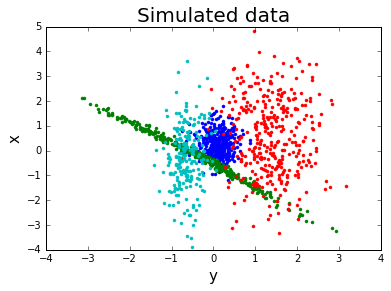

In [94]:
x1,y1,x2,y2,x3,y3,x4,y4 = data()

plt.plot(x1,y1,'.')
plt.plot(x2,y2,'.')
plt.plot(x3,y3,'.')
plt.plot(x4,y4,'.')
plt.xlabel("y",size=15)
plt.ylabel("x",size=15)
plt.title("Simulated data",size=20);

Now assemble the dataset into matrices and optimize the metric:

In [136]:
X = np.vstack( (np.hstack((x1,x2,x3,x4)) , np.hstack((y1,y2,y3,y4))) )
X = np.transpose(X)

Y = np.hstack( (np.zeros(len(x1)),np.ones(len(x2)),2*np.ones(len(x3)),3*np.ones(len(x4))) )

### Large Margin Nearest Neighbor (LMNN)

In [110]:
lmnn = LMNN(k=4, learn_rate=1e-6)
lmnn_metric=np.matrix(lmnn.fit(X,Y).metric())
X_transform = lmnn_metric * np.transpose(np.matrix(X))

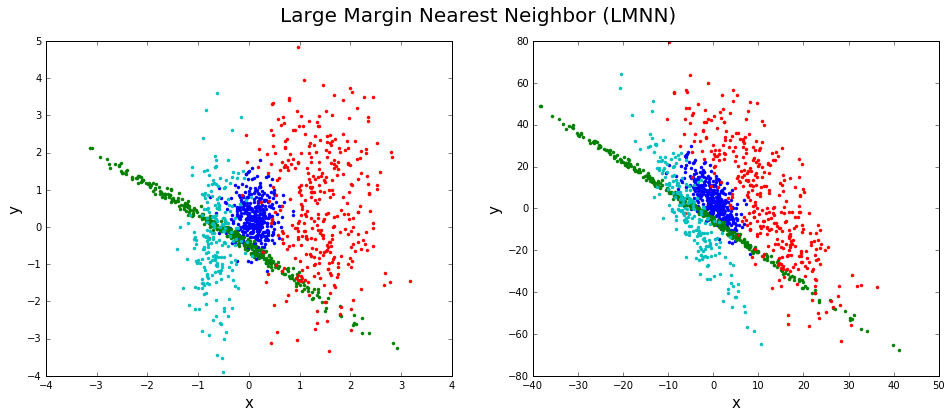

In [130]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'.')
plt.plot(x2,y2,'.')
plt.plot(x3,y3,'.')
plt.plot(x4,y4,'.')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

colors=['b.','g.','r.','c.']
plt.subplot(122)
for i in range(4):
    plt.plot(X_transform[0,Y==i],X_transform[1,Y==i],colors[i])
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Large Margin Nearest Neighbor (LMNN)",size=20)

fig.set_size_inches(16, 6)

### Least Squares Metric Learning (LSML)

In [131]:
lsml = LSML_Supervised(num_constraints=200)
lsml_metric = np.matrix(lsml.fit(X,Y).metric())
X_transform = lsml_metric * np.transpose(np.matrix(X))

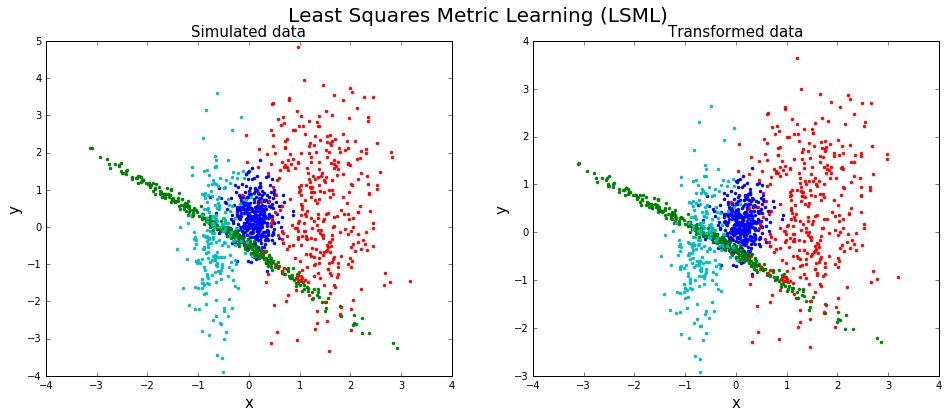

In [133]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'.')
plt.plot(x2,y2,'.')
plt.plot(x3,y3,'.')
plt.plot(x4,y4,'.')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Simulated data",size=15)

plt.subplot(122)
for i in range(4):
    plt.plot(X_transform[0,Y==i],X_transform[1,Y==i],colors[i])
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Transformed data",size=15)

plt.suptitle("Least Squares Metric Learning (LSML)",size=20)

fig.set_size_inches(16, 6)

### Neighborhood Components Analysis (NCA)

In [134]:
nca = NCA(max_iter=1000, learning_rate=0.01)
nca_metric = np.matrix(nca.fit(X, Y).metric())
X_transform = nca_metric * np.transpose(np.matrix(X))

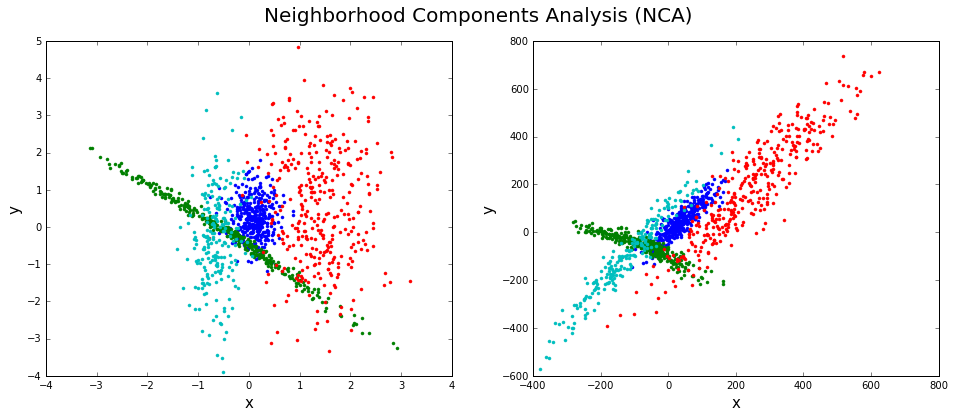

In [135]:
fig = plt.figure()

plt.subplot(121)
plt.plot(x1,y1,'.')
plt.plot(x2,y2,'.')
plt.plot(x3,y3,'.')
plt.plot(x4,y4,'.')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.subplot(122)
for i in range(4):
    plt.plot(X_transform[0,Y==i],X_transform[1,Y==i],colors[i])
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)

plt.suptitle("Neighborhood Components Analysis (NCA)",size=20)

fig.set_size_inches(16, 6)

## Now let's test whether or not learning a metric makes clustering algorithms like K-Means and Gaussian Mixture Models work better

In [138]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GMM

In [147]:
X = np.vstack( (np.hstack((x1t,x2t,x3t,x4t)) , np.hstack((y1t,y2t,y3t,y4t))) )
X = np.transpose(X)

Y = np.hstack( (np.zeros(len(x1t)),np.ones(len(x2t)),2*np.ones(len(x3t)),3*np.ones(len(x4t))) )

A = np.matrix(X) * np.transpose(lsml_metric)

In [139]:
km = KMeans(n_clusters=4,max_iter=20000,init='k-means++',n_init=1000)
Y_pred = km.fit_predict(X)
#Y_pred_trans_DB = DBSCAN(min_samples=10).fit(X).labels_
Y_pred_GM = GMM(n_components=4,n_init=400).fit_predict(X)

In [140]:
print(metrics.normalized_mutual_info_score(Y_pred, Y),
metrics.normalized_mutual_info_score(Y_pred_GM, Y))

0.332941848162 0.334403795756


In [142]:
Y_pred_trans = KMeans(n_clusters=4,max_iter=20000,init='k-means++',n_init=1000).fit_predict(np.transpose(X_transform))
#Y_pred_trans_DB = DBSCAN(min_samples=10).fit(np.matrix(X) * np.transpose(lmnn_metric)).labels_
Y_pred_trans_GM = GMM(n_components=4,n_init=400).fit_predict(np.transpose(X_transform))

In [143]:
print(metrics.normalized_mutual_info_score(Y_pred_trans, Y),
metrics.normalized_mutual_info_score(Y_pred_trans_GM, Y))

0.403547786079 0.360524574832


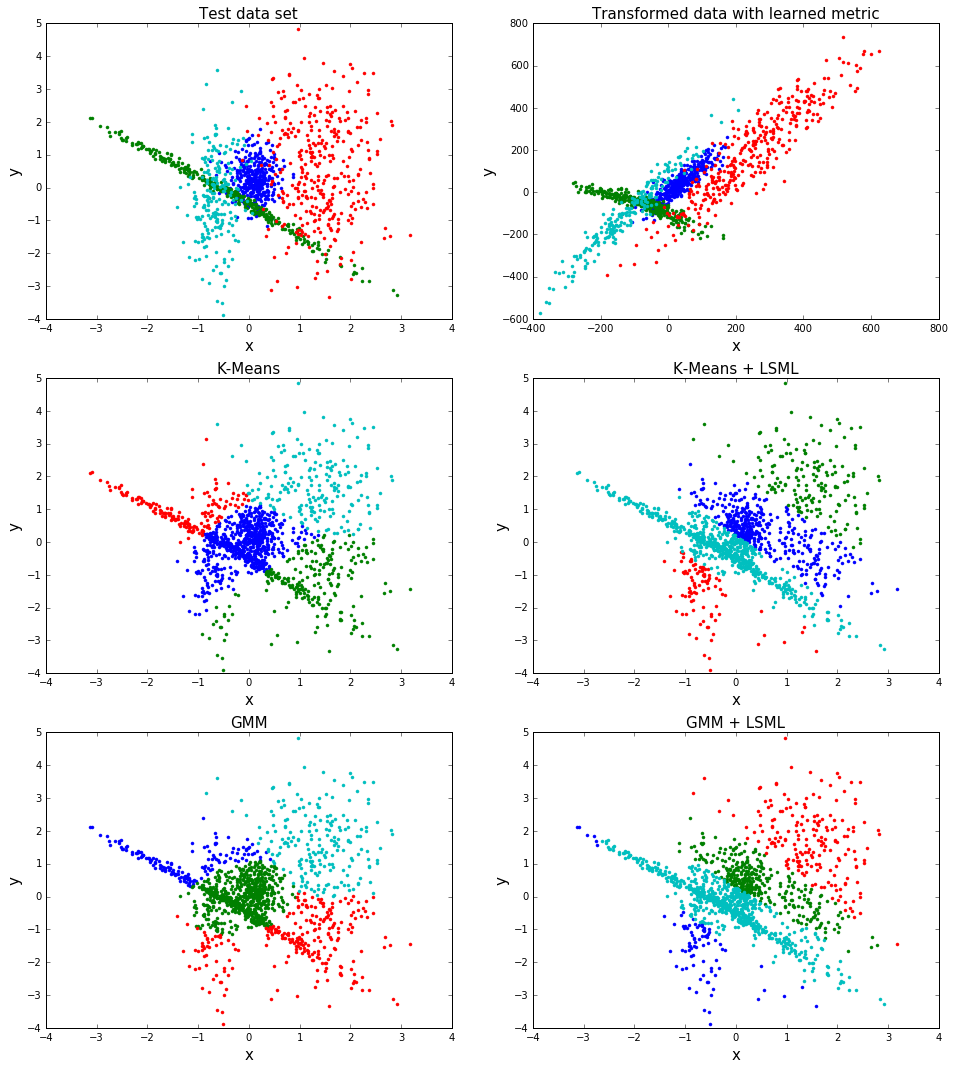

In [148]:
fig = plt.figure()

plt.subplot(321)
plt.plot(x1,y1,'.')
plt.plot(x2,y2,'.')
plt.plot(x3,y3,'.')
plt.plot(x4,y4,'.')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Test data set",size=15)

plt.subplot(322)
for i in range(4):
    plt.plot(np.transpose(X_transform)[Y==i,0],np.transpose(X_transform)[Y==i,1],marker='.', linestyle='none')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("Transformed data with learned metric",size=15)

plt.subplot(323)
for i in range(4):
    plt.plot(X[Y_pred==i,0],X[Y_pred==i,1],marker='.', linestyle='none')
#plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], marker='+', s=100, zorder=1000, color='k')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("K-Means",size=15)

plt.subplot(324)
for i in range(4):
    plt.plot(X[Y_pred_trans==i,0],X[Y_pred_trans==i,1],marker='.', linestyle='none')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("K-Means + LSML",size=15)

plt.subplot(325)
for i in range(4):
    plt.plot(X[Y_pred_GM==i,0],X[Y_pred_GM==i,1],marker='.', linestyle='none')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("GMM",size=15)

plt.subplot(326)
for i in range(4):
    plt.plot(X[Y_pred_trans_GM==i,0],X[Y_pred_trans_GM==i,1],marker='.', linestyle='none')
plt.xlabel("x",size=15)
plt.ylabel("y",size=15)
plt.title("GMM + LSML",size=15)


fig.set_size_inches(16, 18)